# 1 Descriptive analysis
• Read in data using Dask and generate the following descriptive statistics: who were the top 10
countries with the most trading partners, what about the bottom 10?

In [1]:
import dask.dataframe as dd

In [2]:
# trade_data = "E:\\学习\\master\\IPEN5810\\mini group project 2\\trade_data\\trade_data\\"
trade_data = "./trade_data/"
df = dd.read_csv(trade_data + "BACI_HS12_Y*.csv")
df

,t,i,j,k,v,q
npartitions=16,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [3]:
import glob
glob.glob(trade_data + "BACI_HS12_Y*.csv")

['E:\\学习\\master\\IPEN5810\\mini group project 2\\trade_data\\trade_data\\BACI_HS12_Y2016_V202001.csv',
 'E:\\学习\\master\\IPEN5810\\mini group project 2\\trade_data\\trade_data\\BACI_HS12_Y2017_V202001.csv',
 'E:\\学习\\master\\IPEN5810\\mini group project 2\\trade_data\\trade_data\\BACI_HS12_Y2018_V202001.csv']

In [4]:
# Calculate the number of unique trading partners for each country
trading_partners = df.groupby('i')['j'].nunique().compute()

# Sort the countries by the number of trading partners
sorted_countries = trading_partners.sort_values(ascending=False)

# Get the top 10 and bottom 10 countries
top_10_codes = sorted_countries.head(10)
bottom_10_codes = sorted_countries.tail(10)

# Print the results
print("Top 10 countries with the most trading partners:")
print(top_10_codes)

print("\nBottom 10 countries with the least trading partners:")
print(bottom_10_codes)

Top 10 countries with the most trading partners:
i
528    220
276    220
381    219
76     219
251    219
826    219
764    218
724    217
757    217
752    216
Name: j, dtype: int64

Bottom 10 countries with the least trading partners:
i
580    42
574    41
534    37
652    37
583    36
876    36
260    35
666    33
535    17
530     1
Name: j, dtype: int64


In [5]:
# country_codes_df = dd.read_csv("trade_data\\trade_data\\country_codes_V202001.csv", encoding='ISO-8859-1')
country_codes_df = dd.read_csv("trade_data\\trade_data\country_codes_V202001.csv", encoding='ISO-8859-1')

country_codes_df.head()

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND


In [6]:
# Function to map codes to country names
def map_country_names(codes):
    # Filter the country codes DataFrame to include only the specified codes
    mapped_names = country_codes_df[country_codes_df['country_code'].isin(codes.index)]
    # Return the mapping with country names
    return mapped_names[['country_code', 'country_name_full']].set_index('country_code')

# Map top 10 and bottom 10 country codes to names
top_10_countries = map_country_names(top_10_codes).compute()
bottom_10_countries = map_country_names(bottom_10_codes).compute()

# Display the country names for top 10 and bottom 10 countries
print("Top 10 Countries with Most Trading Partners:")
print(top_10_countries)
print("\nBottom 10 Countries with Least Trading Partners:")
print(bottom_10_countries)

Top 10 Countries with Most Trading Partners:
                       country_name_full
country_code                            
76                                Brazil
251                       France, Monaco
276                              Germany
381                                Italy
528                          Netherlands
724                                Spain
752                               Sweden
757           Switzerland, Liechtenstein
764                             Thailand
826                       United Kingdom

Bottom 10 Countries with Least Trading Partners:
                               country_name_full
country_code                                    
260           French South Antarctic Territories
530                         Netherlands Antilles
534                   Saint Maarten (Dutch part)
535            Bonaire, Saint Eustatius and Saba
574                              Norfolk Islands
580                     Northern Mariana Islands
583                Fe

• Match up the trade data with the product and country code; describe the trade volume of the
whole dataset in terms of value and list the five highest value sectors in the entire sample period


In [7]:
# product_codes_df = dd.read_csv("trade_data\\trade_data\\product_codes_HS12_V202001.csv", encoding='ISO-8859-1')
product_codes_df = dd.read_csv("trade_data\\trade_data\product_codes_HS12_V202001.csv", encoding='ISO-8859-1')

In [8]:
# Merge trade data with product descriptions
df = df.merge(product_codes_df[['code', 'description']], left_on='k', right_on='code', how='left')
df = df.drop(columns=['code'])

# Find the top 10 products
top_products = df.groupby('k')['v'].sum().compute().nlargest(10)

In [9]:
top_products_descriptions = product_codes_df[product_codes_df['code'].isin(top_products.index)].compute()

# Print the top products and their descriptions
print("Top Products by Trade Value and Their Descriptions:")
print(top_products_descriptions[['code', 'description']].set_index('code'))

Top Products by Trade Value and Their Descriptions:
                                              description
code                                                     
270900  Oils: petroleum oils and oils obtained from bi...
271000  Petroleum oils and oils from bituminous minera...
300490  Medicaments: consisting of mixed or unmixed pr...
710812  Metals: gold, non-monetary, unwrought (but not...
847130  Automatic data processing machines: portable, ...
851712  Telephones for cellular networks or for other ...
851762  Communication apparatus (excluding telephone s...
854239  Electronic integrated circuits: n.e.c. in head...
870323  Vehicles: spark-ignition internal combustion r...
880240  Aeroplanes and other aircraft: of an unladen w...


In [10]:
# describe the trade volume of the whole dataset in terms of value
average_trade_value = df['v'].mean().compute()
min_trade_value = df['v'].min().compute()
max_trade_value = df['v'].max().compute()

print("Average trade value: ", average_trade_value)
print("Minimum trade value: ", min_trade_value)
print("Maximum trade value: ", max_trade_value)

Average trade value:  2090.4792276332532
Minimum trade value:  1.0
Maximum trade value:  61895755.2124753


The top 5 sectors in the rankings are petroleum, pharmaceuticals, metals, communications, and automobiles

Calculate the top 10 exports (in terms of value) of USA, EU in total, China, and Vietnam over the
sample period

In [11]:
df = df.merge(country_codes_df[['country_code', 'iso_2digit_alpha']], left_on='i', right_on='country_code', 
              how='left')

eu_countries = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 
                'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']

# Function to classify as USA, EU, China, or Vietnam
def classify_country(code):
    if code == 'US':
        return 'USA'
    elif code in eu_countries:
        return 'EU'
    elif code == 'CN':
        return 'China'
    elif code == 'VN':
        return 'Vietnam'
    return 'Other'

df['region'] = df['iso_2digit_alpha'].apply(classify_country, meta=('i', 'object'))

# Filter for the countries of interest
filtered_df = df[df['region'].isin(['USA', 'EU', 'China', 'Vietnam'])]

# Calculate top 10 exports by value for each region
top_exports_by_value = filtered_df.groupby(['region', 'k'])['v'].sum().nlargest(10).compute()

print("Top 10 exports by value for USA, EU, China, and Vietnam:")
print(top_exports_by_value)


Top 10 exports by value for USA, EU, China, and Vietnam:
region  k     
China   851712    5.260866e+08
EU      300490    4.792134e+08
        271000    4.580843e+08
        870323    3.191505e+08
China   847130    3.136846e+08
EU      870332    3.097975e+08
        880240    2.443456e+08
USA     271000    2.308764e+08
EU      300210    2.068151e+08
China   851770    1.676517e+08
Name: v, dtype: float64


In [12]:
# Find exports' descriptions for the top 10 exports by value
top_exports_descriptions = product_codes_df[product_codes_df['code'].
                                            isin(top_exports_by_value.index.get_level_values('k'))].compute()
# Print the top exports and their descriptions
print("Top Exports by Value for USA, EU, China, and Vietnam:")
print(top_exports_descriptions[['code', 'description']].set_index('code'))

Top Exports by Value for USA, EU, China, and Vietnam:
                                              description
code                                                     
271000  Petroleum oils and oils from bituminous minera...
300210  Blood, human or animal, antisera, other blood ...
300490  Medicaments: consisting of mixed or unmixed pr...
847130  Automatic data processing machines: portable, ...
851712  Telephones for cellular networks or for other ...
851770  Telephone sets and other apparatus for the tra...
870323  Vehicles: spark-ignition internal combustion r...
870332  Vehicles: compression-ignition internal combus...
880240  Aeroplanes and other aircraft: of an unladen w...


Calculate the top 10 goods with the highest trade volume for both exports and imports in terms of value and quantity

In [13]:
# Find country codes for the EU countries
eu_country_codes = country_codes_df[country_codes_df['iso_2digit_alpha']
                                    .isin(eu_countries)]['country_code'].compute()
eu_country_codes = eu_country_codes.tolist()

countries_of_interest = {
    'USA': [842],  
    'EU': eu_country_codes,  
    'China': [156],  
    'Vietnam': [704]  
}

In [14]:
results = {}

for country, codes in countries_of_interest.items():
    if not isinstance(codes, list):
        codes = [codes]
    
    exports = df[df['i'].isin(codes)]
    imports = df[df['j'].isin(codes)]
    
    top_exports_by_value = exports.groupby(['k', 'description'])['v'].sum().nlargest(10).compute()
    top_exports_by_quantity = exports.groupby(['k', 'description'])['q'].sum().nlargest(10).compute()
    top_imports_by_value = imports.groupby(['k', 'description'])['v'].sum().nlargest(10).compute()
    top_imports_by_quantity = imports.groupby(['k', 'description'])['q'].sum().nlargest(10).compute()

    results[country] = {
        'Top 10 Exports by Value': top_exports_by_value,
        'Top 10 Exports by Quantity': top_exports_by_quantity,
        'Top 10 Imports by Value': top_imports_by_value,
        'Top 10 Imports by Quantity': top_imports_by_quantity,
    }

# Print results
for country, data in results.items():
    print(f"Results for {country}:")
    for key, value in data.items():
        print(f"{key}:")
        print(value)
        print()


Results for USA:
Top 10 Exports by Value:
k       description                                                                                                                                                                                                                             
271000  Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    2.308764e+08
880240  Aeroplanes and other aircraft: of an unladen weight exceeding 15,000kg                                                                                                                                                                      1.604832e+08
300490  Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                    

Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen country and all the other centroids. You may use either haversine distance with the geographic CRS or use a projected CRS and use the distance function of geopandas. Please also create a scatterplot of distance and export volume (quantity and value) in logarithm form

In [15]:
import geopandas as gpd

# Load the country shapefile
gdf = gpd.read_file('countries_shapefile\\cn_primary_countries.shp')

# Calculate the centroids of each country
gdf['centroid'] = gdf.geometry.centroid

C:\Users\Quincy\AppData\Local\Temp\ipykernel_344\4208552709.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


In [16]:
gdf.head()

,ADM0_A3,abbrev,continent,formal_nam,iso_a2,iso_a3,iso_n3,iso_short,name,name_sort,...,un_n3,un_region,un_ru,un_subregi,un_zh,wb_a2,wb_a3,wb_region,geometry,centroid
0,AFG,Afg.,Asia,Islamic State of Afghanistan,AF,AFG,4,Afghanistan,Afghanistan,Afghanistan,...,4,Asia,Афганистан,Southern Asia,阿富汗,AF,AFG,South Asia,"POLYGON ((74.89231 37.23111, 74.81314 37.21543...",POINT (66.00845 33.83627)
1,AGO,Ang.,Africa,People's Republic of Angola,AO,AGO,24,Angola,Angola,Angola,...,24,Africa,Ангола,Middle Africa,安哥拉,AO,AGO,Sub-Saharan Africa,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",POINT (17.53699 -12.29232)
2,ALB,Alb.,Europe,Republic of Albania,AL,ALB,8,Albania,Albania,Albania,...,8,Europe,Албания,Southern Europe,阿尔巴尼亚,AL,ALB,Europe & Central Asia,"POLYGON ((20.06496 42.54676, 20.08563 42.53001...",POINT (20.05382 41.14248)
3,AND,And.,Europe,Principality of Andorra,AD,AND,20,Andorra,Andorra,Andorra,...,20,Europe,Андорра,Southern Europe,安道尔,AD,ADO,Europe & Central Asia,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",POINT (1.56076 42.54133)
4,ARE,U.A.E.,Asia,United Arab Emirates,AE,ARE,784,United Arab Emirates (the),United Arab Emirates,United Arab Emirates,...,784,Asia,Объединенные Арабские Эмираты,Western Asia,阿拉伯联合酋长国,AE,ARE,Middle East & North Africa,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24...",POINT (54.30080 23.90578)


In [17]:
# Select the centroid of the USA
usa_centroid = gdf[gdf['iso_a3'] == 'USA']['centroid'].squeeze() 


In [18]:
from shapely.geometry import Point
import numpy as np

def haversine(point1, point2):
    lon1, lat1, lon2, lat2 = map(np.radians, [point1.x, point1.y, point2.x, point2.y])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Apply distance calculation
gdf['distance_from_usa'] = gdf['centroid'].apply(lambda x: haversine(usa_centroid, x))


In [19]:
gdf = dd.from_pandas(gdf, npartitions=1)
gdf.head()

,ADM0_A3,abbrev,continent,formal_nam,iso_a2,iso_a3,iso_n3,iso_short,name,name_sort,...,un_region,un_ru,un_subregi,un_zh,wb_a2,wb_a3,wb_region,geometry,centroid,distance_from_usa
0,AFG,Afg.,Asia,Islamic State of Afghanistan,AF,AFG,4,Afghanistan,Afghanistan,Afghanistan,...,Asia,Афганистан,Southern Asia,阿富汗,AF,AFG,South Asia,"POLYGON ((74.89231 37.23111, 74.81314 37.21543...",POINT (66.00845 33.83627),11171.098086
1,AGO,Ang.,Africa,People's Republic of Angola,AO,AGO,24,Angola,Angola,Angola,...,Africa,Ангола,Middle Africa,安哥拉,AO,AGO,Sub-Saharan Africa,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",POINT (17.53699 -12.29232),14038.851049
2,ALB,Alb.,Europe,Republic of Albania,AL,ALB,8,Albania,Albania,Albania,...,Europe,Албания,Southern Europe,阿尔巴尼亚,AL,ALB,Europe & Central Asia,"POLYGON ((20.06496 42.54676, 20.08563 42.53001...",POINT (20.05382 41.14248),9273.002844
3,AND,And.,Europe,Principality of Andorra,AD,AND,20,Andorra,Andorra,Andorra,...,Europe,Андорра,Southern Europe,安道尔,AD,ADO,Europe & Central Asia,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",POINT (1.56076 42.54133),8239.347509
4,ARE,U.A.E.,Asia,United Arab Emirates,AE,ARE,784,United Arab Emirates (the),United Arab Emirates,United Arab Emirates,...,Asia,Объединенные Арабские Эмираты,Western Asia,阿拉伯联合酋长国,AE,ARE,Middle East & North Africa,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24...",POINT (54.30080 23.90578),12162.215431


In [20]:
import pandas as pd
import numpy as np

# Select data for exports from the USA
exports_from_usa = df[df['i'] == 842]

# Compute the total exports by country
total_exports_by_country = exports_from_usa.groupby('j')['q'].sum().reset_index()
total_exports_by_country = total_exports_by_country.rename(columns={'j': 'country_code', 'q': 'total_exports'})

# Compute log
total_exports_by_country['log_total_exports'] = np.log1p(total_exports_by_country['total_exports'])

In [21]:
# Add the ISO 2-digit country codes to the DataFrame

total_exports_by_country = total_exports_by_country.merge(
    country_codes_df[['country_code', 'iso_2digit_alpha']],
    on='country_code',
    how='left'
)

# Delete the geometry and centroid columns from the GeoDataFrame
gdf_simplified = gdf.drop(columns=['geometry', 'centroid'])

gdf_simplified = gdf_simplified.merge(total_exports_by_country[['iso_2digit_alpha', 'log_total_exports']],
                                      left_on='iso_a2',
                                      right_on='iso_2digit_alpha',
                                      how='left')



In [22]:
print(gdf_simplified.columns)


Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'distance_from_usa', 'iso_2digit_alpha',
       'log_total_exports'],
      dtype='object')


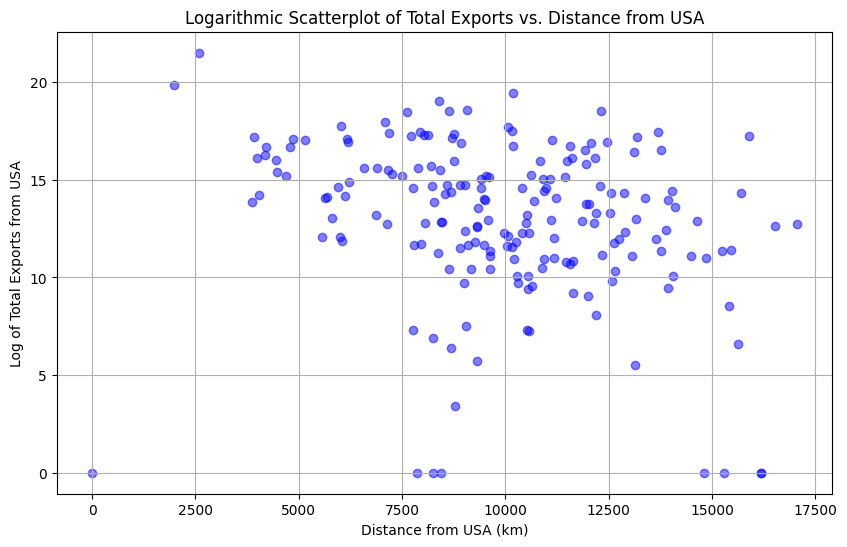

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure that the log_total_exports column has no missing values
gdf_simplified['log_total_exports'] = gdf_simplified['log_total_exports'].fillna(0)

# Draw a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(gdf_simplified['distance_from_usa'], gdf_simplified['log_total_exports'], color='blue', alpha=0.5)
plt.xlabel('Distance from USA (km)')
plt.ylabel('Log of Total Exports from USA')
plt.title('Logarithmic Scatterplot of Total Exports vs. Distance from USA')
plt.grid(True)
plt.show()


# 2 Unsupervised Learning: Identifying Trade Patterns

1. Normalize the trade data (e.g., using min-max scaling or standardization) to ensure comparability across different sectors and countries

In [3]:
df_head = df.head()
print(df_head)

      t  i   j       k           v        q
0  2016  4  12   80132   26.313000    3.000
1  2016  4  12  130190    1.507000    0.585
2  2016  4  12  370239    1.121000    0.003
3  2016  4  12  970600   17.236000    0.019
4  2016  4  24  480300  315.120626  186.534


In [4]:
# Standardization using mean and standard deviation for columns 'v' and 'q'
mean_v = df['v'].mean().compute()
std_v = df['v'].std().compute()

mean_q = df['q'].mean().compute()
std_q = df['q'].std().compute()

# Standardize the 'v' column
df['v_standardized'] = (df['v'] - mean_v) / std_v

# Standardize the 'q' column
df['q_standardized'] = (df['q'] - mean_q) / std_q

In [5]:
df_head = df.head()
print(df_head)

      t  i   j       k           v        q  v_standardized  q_standardized
0  2016  4  12   80132   26.313000    3.000       -0.030865       -0.004627
1  2016  4  12  130190    1.507000    0.585       -0.031236       -0.004633
2  2016  4  12  370239    1.121000    0.003       -0.031242       -0.004635
3  2016  4  12  970600   17.236000    0.019       -0.031001       -0.004635
4  2016  4  24  480300  315.120626  186.534       -0.026546       -0.004180


2. Apply an unsupervised learning technique such as K-means clustering or Hierarchical clustering to identify distinct groups of countries based on their trade patterns (e.g., export/import values, sectors, distance)

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
import pandas as pd

In [7]:
# Group by 'i' and compute aggregates
grouped_by_i = df.groupby('i')

# Generate features separately
country_features = pd.DataFrame()
country_features['focal_country'] = df['i'].unique()
country_features['country_number'] = grouped_by_i['j'].nunique()
country_features['country_diversity'] = grouped_by_i['j'].std()
country_features['product_number'] = grouped_by_i['k'].nunique()
country_features['product_diversity'] = grouped_by_i['k'].std()
country_features['value_mean'] = grouped_by_i['v_standardized'].mean()
country_features['value_diversity'] = grouped_by_i['v_standardized'].std()

country_features = country_features.reset_index()

In [8]:
# Display the final features DataFrame
print(country_features.head())

   index  focal_country  country_number  country_diversity  product_number  \
0      0              4             128         263.254414            1438   
1      1              8             129         238.839447            2609   
2      2             12             152         251.424934            1812   
3      3             16              89         302.569622             634   
4      4             20             136         240.388820            1674   

   product_diversity  value_mean  value_diversity  
0      313236.676735   -0.021905         0.088412  
1      613892.894592   -0.026703         0.046009  
2      582761.744442    0.154737         1.917273  
3      281402.261598   -0.029363         0.012073  
4      658391.248920   -0.030305         0.008017  


In [9]:
# Standardize the std
def standardize_columns(df, columns):
    # Compute mean and std for each column
    means = {col: df[col].mean() for col in columns}
    stds = {col: df[col].std() for col in columns}

    # Standardize the specified columns
    for col in columns:
        df[col + '_standardized'] = (df[col] - means[col]) / stds[col]

    return df

# Apply standardization to specified columns in 'country_features'
columns_to_standardize = ['country_diversity', 'product_diversity', 'value_diversity']
country_features = standardize_columns(country_features, columns_to_standardize)

country_features

,index,focal_country,country_number,country_diversity,product_number,product_diversity,value_mean,value_diversity,country_diversity_standardized,product_diversity_standardized,value_diversity_standardized
0,0,4,128,263.254414,1438,313236.676735,-0.021905,0.088412,0.374440,-1.049671,-0.412824
1,1,8,129,238.839447,2609,613892.894592,-0.026703,0.046009,-0.535747,0.584168,-0.456095
2,2,12,152,251.424934,1812,582761.744442,0.154737,1.917273,-0.066562,0.414994,1.453443
3,3,16,89,302.569622,634,281402.261598,-0.029363,0.012073,1.840105,-1.222667,-0.490725
4,4,20,136,240.388820,1674,658391.248920,-0.030305,0.008017,-0.477986,0.825983,-0.494864
...,...,...,...,...,...,...,...,...,...,...,...
217,217,876,36,270.772201,101,220794.451909,-0.031084,0.000324,0.654701,-1.552025,-0.502714
218,218,882,84,310.300616,1033,314609.071736,-0.029835,0.009324,2.128315,-1.042213,-0.493530
219,219,887,90,242.525694,777,312052.245361,-0.003774,0.344413,-0.398324,-1.056108,-0.151588
220,220,894,132,253.581473,2378,638000.567018,0.008449,0.675652,0.013834,0.715175,0.186426


In [10]:
country_features= country_features.drop(columns=[ 'product_diversity', 'value_diversity', 'country_diversity'])

In [11]:
# note that the top product/export country information is not considered in the k-means clustering
# since it doesn't directly handle categorical data well
# the concept of 'distance' doesn't naturally apply to categorical variables
# also the same for PCA analysis, Applying PCA directly to categorical data (factors) isn't suitable. 
# For mixed data (numerical and categorical), techniques like Multiple Correspondence Analysis (MCA) are designed to handle that scenario.

class TradeKmeansModel:
    def __init__(self, data):
        self.df = data

    def fit(self, num_clusters):
        trade_features = self.df[['country_number','country_diversity_standardized', 'product_number', 'product_diversity_standardized', 
                                  'value_mean','value_diversity_standardized']]
        self.K = num_clusters
        self.model = KMeans(n_clusters=self.K, n_init="auto", random_state=0).fit(trade_features)

    def predict(self):
        trade_features = self.df[['country_number','country_diversity_standardized', 'product_number', 'product_diversity_standardized', 
                                  'value_mean','value_diversity_standardized']]
        self.prediction = self.model.predict(trade_features)
        return self.prediction

    def sil_score(self):
        trade_features = self.df[['country_number','country_diversity_standardized', 'product_number', 'product_diversity_standardized', 
                                  'value_mean','value_diversity_standardized']]
        return silhouette_score(trade_features, self.model.predict(trade_features), sample_size=1000)

def score_by_k(data, K):
    model = TradeKmeansModel(data)
    model.fit(K)
    return model.sil_score()

def inertia_by_k(data, K):
    model = TradeKmeansModel(data)
    model.fit(K)
    return model.model.inertia_

In [12]:
K = 20

In [13]:
# to find the best cluster number

init_scores = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i in range(2, K):
        inertia = inertia_by_k(country_features, i)
        init_scores.append(inertia)

  File "D:\Softwares\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Softwares\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Softwares\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Softwares\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


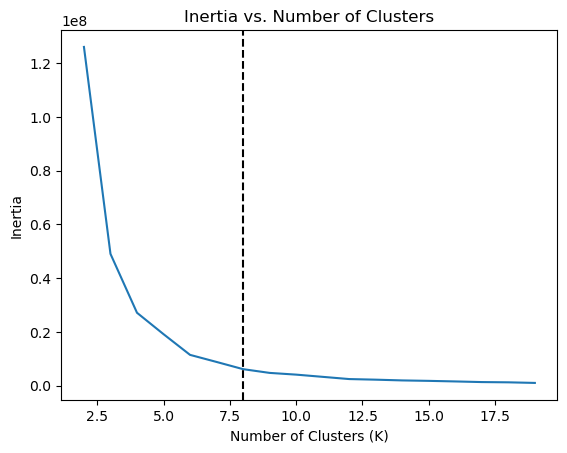

In [14]:
# Plot the inertia values against the number of clusters
plt.plot(range(2, K), init_scores)
plt.axvline(8, color="black", ls="--")
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.show()

In [15]:
import os

# Set the OMP_NUM_THREADS environment variable to 1
os.environ["OMP_NUM_THREADS"] = "1"

# the best cluster number is 8
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = TradeKmeansModel(country_features)
    model.fit(8)
    country_features['k_mean_cluster'] = model.predict()

In [16]:
country_features.head()

,index,focal_country,country_number,product_number,value_mean,country_diversity_standardized,product_diversity_standardized,value_diversity_standardized,k_mean_cluster
0,0,4,128,1438,-0.021905,0.374440,-1.049671,-0.412824,3
1,1,8,129,2609,-0.026703,-0.535747,0.584168,-0.456095,2
2,2,12,152,1812,0.154737,-0.066562,0.414994,1.453443,3
3,3,16,89,634,-0.029363,1.840105,-1.222667,-0.490725,7
4,4,20,136,1674,-0.030305,-0.477986,0.825983,-0.494864,3


3. Visualize the resulting clusters using techniques like Principal Component Analysis (PCA)
or t-SNE to reduce the dimensionality of the data and create informative plots

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
class PCA_Model:
    def __init__(self, ncomps, data, cols):
        self.ncomps = ncomps
        self.cols = cols
        self.data = data
        self.scaled_data = StandardScaler().fit_transform(data[cols].values)
        
    def fit(self):
        self.PCA_obj = PCA(self.ncomps).fit(self.scaled_data)
    
    def describe(self):
        explvar_ = self.PCA_obj.explained_variance_ratio_
        explvar = pd.DataFrame(explvar_[np.newaxis, :] * 100,
                               columns=[str(x) for x in range(1, self.ncomps + 1)],
                               index=["% Explained Variance"])
        loadscores_ = self.PCA_obj.components_
        loadscores = pd.DataFrame(loadscores_,
                                  columns=self.cols,
                                  index=["Component " + str(x) for x in range(1, self.ncomps + 1)])
        total_variance_explained = sum(explvar_) * 100
        explained_variance = self.PCA_obj.explained_variance_
        print(f"Explains {total_variance_explained:.2f}% of the variance")
        print("Explained variance:", explained_variance)
        print(explvar)
        print(loadscores)
        return explvar, loadscores, explained_variance
    
    def gen_data(self):
        return pd.DataFrame(self.PCA_obj.transform(self.scaled_data))

    def plot_explained_variance(self):
        explained_variance_ratio_cumsum = self.PCA_obj.explained_variance_ratio_.cumsum()
        explained_variance = self.PCA_obj.explained_variance_
        
        # Create initial plot
        fig, ax1 = plt.subplots(figsize=(8, 6))

        # First axis (left y-axis)
        ax1.plot(range(1, self.ncomps + 1), explained_variance_ratio_cumsum, marker='o', linestyle='-', 
                 label='Cumulative Explained Variance')
        ax1.bar(range(1, self.ncomps + 1), self.PCA_obj.explained_variance_ratio_, color='lightblue', 
                label='Explained Variance Ratio')
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Explained Variance Ratio')

        # Second axis (right y-axis)
        ax2 = ax1.twinx()
        ax2.plot(range(1, self.ncomps + 1), explained_variance, color='red', marker='^', linestyle='--', 
                 label='Actual Explained Variance')
        ax2.axhline(1, ls="--", color='black', label='Eigenvalue rule')
        ax2.set_ylabel('Actual Explained Variance')

        # Handles, Labels for creating unified legend 
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

        plt.title('Explained Variance vs. Number of Components')
        plt.show()

Explains 99.41% of the variance
Explained variance: [2.7807377  1.87814315 1.06960906 0.95139672 0.22345999 0.08649116]
                              1          2        3          4         5  \
% Explained Variance  39.545884  26.709758  15.2113  13.530159  3.177906   

                             6  
% Explained Variance  1.230022  
                index  country_number  product_number  value_mean  \
Component 1  0.011646       -0.576260       -0.576438   -0.082488   
Component 2 -0.013517       -0.100982       -0.105203    0.708745   
Component 3  0.679417       -0.076259        0.046003    0.011827   
Component 4 -0.732108       -0.029425        0.002950    0.006740   
Component 5 -0.013753       -0.384756       -0.405244   -0.016943   
Component 6 -0.016557       -0.132988        0.077695   -0.692306   

             country_diversity_standardized  product_diversity_standardized  \
Component 1                       -0.021660                       -0.542932   
Component 2        

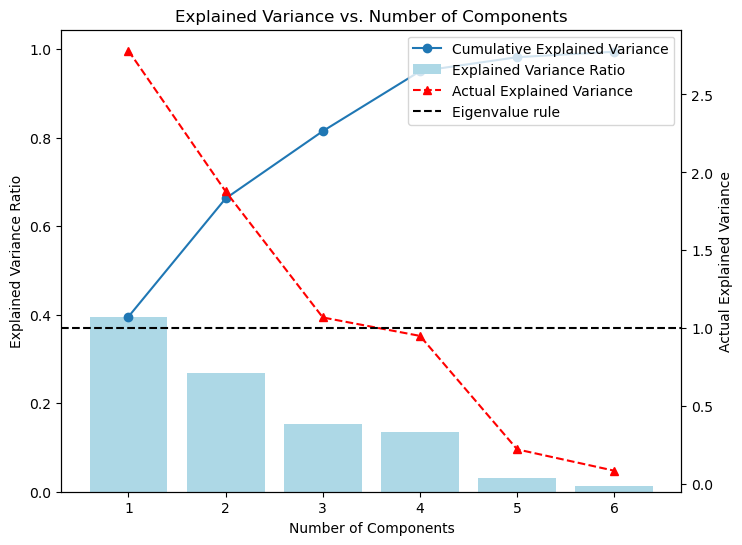

In [19]:
import numpy as np

pca_model = PCA_Model(6, country_features, country_features.columns.drop(['focal_country', 'k_mean_cluster']))
pca_model.fit()
var, load_scores, explained_variance = pca_model.describe()
pca_model.plot_explained_variance()

In [20]:
# Fit PCA model and transform data to reduced dimensions
features = country_features.drop(['focal_country', 'k_mean_cluster'], axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Applying PCA
pca = PCA(n_components=3)
pca_results = pca.fit(scaled_features)

load_scores = pd.DataFrame(pca_results.components_)
load_scores.columns = country_features.drop(['focal_country', 'k_mean_cluster'], axis=1).columns
load_scores.T

,0,1,2
index,0.011646,-0.013517,0.679417
country_number,-0.576260,-0.100982,-0.076259
product_number,-0.576438,-0.105203,0.046003
value_mean,-0.082488,0.708745,0.011827
country_diversity_standardized,-0.021660,0.016489,-0.724856
product_diversity_standardized,-0.542932,-0.118718,0.065060
value_diversity_standardized,-0.182918,0.679608,0.025920


- Principal Component 1 (PC1)
    - For PC1, the most significant contributors (in terms of magnitude) are country_number and product_number both with roughly equivalent negative loadings of -0.576. 
    - Since PC1 captures the most variance in the dataset, this suggests that variations in the number of export countries and product types are crucial aspects defining the dataset's overall variability.

- Principal Component 2 (PC2)
    - For PC2, value_mean and value_diversity_standardized are the dominant contributors with positive loadings of 0.708 and 0.679, respectively. 
    - This signals that the average value and diversity in product value contribute significantly to the variance captured by the second principal component.
    - And they do so in a directly proportional manner.

- Principal Component 3 (PC3)
    - PC3 is most heavily influenced by country_diversity_standardized with a significant negative loading of -0.993. 

In [21]:
pca_df = pd.DataFrame(data = pca.fit_transform(scaled_features), columns = ['PC1', 'PC2', 'PC3'])

In [22]:
pca_df['k_mean_cluster'] = country_features['k_mean_cluster'].values
pca_df['focal_country'] = country_features['focal_country'].values
pca_df

,PC1,PC2,PC3,k_mean_cluster,focal_country
0,1.070400,-0.252615,-1.539370,3,4
1,-0.180304,-0.615423,-0.733615,2,8
2,-0.652763,2.669181,-1.045366,3,12
3,1.827455,-0.222244,-2.554354,7,16
4,-0.066401,-0.665659,-0.763845,3,20
...,...,...,...,...,...
217,2.802913,-0.145734,0.612574,1,876
218,1.684035,-0.306103,-0.455384,7,882
219,1.673035,0.171057,1.388470,7,887
220,-0.340774,0.155777,1.210248,5,894


In [23]:
# filter outlier
pca_df = pca_df[~((pca_df['PC2'] > 10)| (pca_df['PC3'] >4))]

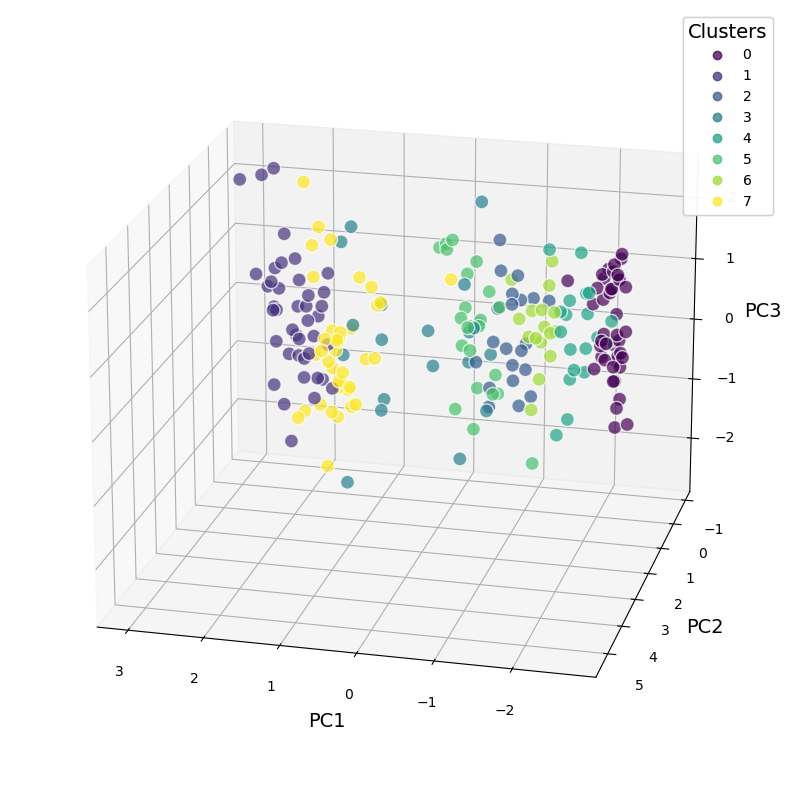

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a larger figure for better visibility
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract individual columns
x = pca_df['PC1']
y = pca_df['PC2']
z = pca_df['PC3']
c = pca_df['k_mean_cluster']

# Generate a 3D scatter plot with increased marker size and transparency
scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=100, alpha=0.7, edgecolor='w')

# Set labels for axes with a larger font size
ax.set_xlabel('PC1', fontsize=14, labelpad = 15)
ax.set_ylabel('PC2', fontsize=14, labelpad = 15)
ax.set_zlabel('PC3', fontsize=14, labelpad = 15)

# Add gridlines for better readability
ax.grid(True)

# Add legend with the unique colors from the 'k_mean_cluster'
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
legend1.get_title().set_fontsize('14') # Set the fontsize for legend title
ax.add_artist(legend1)

# Set better viewing angles for improved perspective
ax.view_init(elev=20, azim=104)

# Increase distance of tick labels from the axis (optional for aesthetics)
ax.tick_params(axis='both', which='major', pad=10)

# Show the plot
plt.show()


In [25]:
# Creating a text column for hover information
pca_df["text_info"] = "Cluster: " + pca_df["k_mean_cluster"].astype(str) + "<br>Country: " + pca_df["focal_country"].astype(str)
pca_df

,PC1,PC2,PC3,k_mean_cluster,focal_country,text_info
0,1.070400,-0.252615,-1.539370,3,4,Cluster: 3<br>Country: 4
1,-0.180304,-0.615423,-0.733615,2,8,Cluster: 2<br>Country: 8
2,-0.652763,2.669181,-1.045366,3,12,Cluster: 3<br>Country: 12
3,1.827455,-0.222244,-2.554354,7,16,Cluster: 7<br>Country: 16
4,-0.066401,-0.665659,-0.763845,3,20,Cluster: 3<br>Country: 20
...,...,...,...,...,...,...
216,-0.768525,2.766526,1.089666,5,862,Cluster: 5<br>Country: 862
217,2.802913,-0.145734,0.612574,1,876,Cluster: 1<br>Country: 876
218,1.684035,-0.306103,-0.455384,7,882,Cluster: 7<br>Country: 882
219,1.673035,0.171057,1.388470,7,887,Cluster: 7<br>Country: 887


In [26]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot

# Generate a 3D scatter plot
trace = go.Scatter3d(
    x=pca_df['PC1'],
    y=pca_df['PC2'],
    z=pca_df['PC3'],
    mode='markers',
    marker=dict(
        size=10,
        color=pca_df['k_mean_cluster'],  # Set color to the cluster identifiers
        colorscale='Viridis',  # Color scale
        opacity=0.7,
        line=dict(
            color='white', 
            width=0.5
        )
    ),
    text=pca_df["text_info"],  # Assign the hover text
    hoverinfo="text"
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3')
    ),
    legend_title=dict(text='Cluster Legend')
)

fig = go.Figure(data=[trace], layout=layout)

filename = './interactive_cluster_plot.html'
plot(fig, filename=filename)

'./interactive_cluster_plot.html'

4. Analyze the characteristics of each cluster and discuss potential insights or implications for understanding trade dynamics and patterns among countries

- Summary of the PCA analysis
    - The first component is strongly associated with the numbers of export countries and product types.
    - The second component is primarily influenced by the mean and diversity of the product values.
    - The third component is predominantly related to the standardized diversity among export countries.


- Implications for Understanding Trade Dynamics and Patterns
    - Cluster Patterns Reflecting Export Portfolio Size and Diversity (PC1): 
        - The strong association of PC1 with both `country_number` and `product_number` underlines a dimension of export scale and diversification. 
        - Countries that score high on PC1 are not just exporting to many countries but are also exporting a wide range of products. 
        -  This characteristic could signify robust and versatile economies that do not overly depend on a limited set of trading partners or product types. 
        - For nations within this cluster, the focus could be on expanding market reach and innovating within product lines to maintain or enhance their position in the global trade network.
    
    - Cluster Patterns Highlighting Export Value (PC2): 
        - The significant positive correlation of PC2 with value_mean underscores an aspect of the economic value that different countries' export products hold. 
        - Countries that stand out on this component likely deal in exports that, on average, are of higher value. This could point towards a specialization in high-value industries or advanced manufacturing capabilities. 
        - For these countries, policy and investment strategies that nurture high-value sectors, improve product quality, and enhance brand value on the global stage might be particularly beneficial.

    - Cluster Patterns Indicating Partner Diversity (PC3): 
        - Unlike PC1 and PC2, PC3 uniquely reveals insights into the diversity of trading partners a country engages with, Identified through its strong negative tie with country_diversity_standardized. 
        - Countries that score lower on PC3 tend to engage in trade with a broader array of countries, suggesting flexibility and a robust network in their trade relations. 
        - This broad engagement indicates not just economic strength but also diplomatic reach, suggesting these nations might be well-positioned to broker international collaborations and navigate global economic fluctuations more resiliently.

# Machine Learning: Predicting Trade Flows

1. Split your dataset into training and testing sets, with 80% of the data used for training and
20% for testing

In [50]:
from dask_ml.model_selection import train_test_split

In [51]:
df.head()

,t,i,j,k,v,q,description,country_code,iso_2digit_alpha,v_standardized,q_standardized
0,2016,4,12,80132,26.313000,3.000,"Nuts, edible: cashew nuts, fresh or dried, she...",4,AF,-0.030865,-0.004627
1,2016,4,12,130190,1.507000,0.585,"Natural gums, resins, gum-resins and oleoresin...",4,AF,-0.031236,-0.004633
2,2016,4,12,370239,1.121000,0.003,"Photographic film: in rolls, (other than with ...",4,AF,-0.031242,-0.004635
3,2016,4,12,970600,17.236000,0.019,Antiques: of an age exceeding one hundred years,4,AF,-0.031001,-0.004635
4,2016,4,24,480300,315.120626,186.534,"Tissue, towel, napkin stock or similar: for ho...",4,AF,-0.026546,-0.004180


In [52]:
df = df.drop(['description', 'country_code', 'iso_2digit_alpha', 'v', 'q'], axis = 1)

In [53]:
# summarize the sector information of the product types based on the first 2 numbers of the product code
df['sector'] = df['k'].astype(str).str[:2]
df.head()

,t,i,j,k,v_standardized,q_standardized,sector
0,2016,4,12,80132,-0.030865,-0.004627,80
1,2016,4,12,130190,-0.031236,-0.004633,13
2,2016,4,12,370239,-0.031242,-0.004635,37
3,2016,4,12,970600,-0.031001,-0.004635,97
4,2016,4,24,480300,-0.026546,-0.004180,48


In [54]:
# convert some columns to categorical types
df_categorical = df.categorize(columns=['t', 'i', 'j', 'sector'])

# use get_dummies to one-hot encode these categorical columns
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_categorical_encoded = dd.get_dummies(df_categorical[['t', 'i', 'j', 'sector']])
    X = dd.concat([X_categorical_encoded, df[['v_standardized']]], axis=1)

y = df['q_standardized']
X.head()

,t_2016,t_2017,t_2018,i_4,i_8,i_12,i_16,i_20,i_24,i_28,...,sector_89,sector_90,sector_91,sector_92,sector_93,sector_94,sector_95,sector_96,sector_97,v_standardized
0,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.030865
1,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.031236
2,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.031242
3,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,-0.031001
4,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.026546


In [55]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

2. Using the training set, build a machine learning model (e.g., Random Forest, Gradient Boosting, or Neural Network) to predict the export quantity based on features such as distance, GDP, and sector. Perform any necessary feature engineering and hyperparameter tuning.

In [56]:
# random forest model applied to Dask dataframe always runs into errors
# the following operations are based on the pd dataframe
# thus, some operations may not be replicateable sorely rely on the notebook
# I actually run the code on a remote server

df = df.drop(['k'], axis = 1)
df.compute().to_csv('./ML_trade.csv', index=False)
df = pd.read_csv('./ML_trade.csv')

- feature engineering
    - including 2 steps: 
        - 1. standardization the numeric variables: 'v', 'q' to 'v_standardized','q_standardized'
        - 2. treat the i, j, sector information as factor variables
- the following step will usually cause memory error

In [57]:
df_categorical = df.astype({'t': 'category', 'i': 'category', 'j': 'category', 'sector': 'category'})

# Now you can use get_dummies to one-hot encode these categorical columns
X_categorical_encoded = pd.get_dummies(df_categorical[['t', 'i', 'j', 'sector']])
X = pd.concat([X_categorical_encoded, df[['v_standardized']]], axis=1)
y = df['q_standardized']
y = y.values.ravel()

# Confirm the sample sizes
print(f'Sample X size: {X.shape}')
print(f'Sample y size: {y.shape}')

Sample X size: (24025656, 534)
Sample y size: (24025656,)


We can see that treating some variables as factors significantly increases the X sample size

- hyperparameter tuning
    - generate a subset of the whole dataset
    - operate a grid search to detect the best model parameters

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib

In [ ]:
# generate a subset to explore the parameter combinations
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.999, random_state=42, shuffle=True)

X_sample.to_csv('./X_sample.csv', index=False)
y_sample.to_csv('./y_sample.csv', index=False)

In [2]:
X_sample = pd.read_csv('X_sample.csv')
y_sample = pd.read_csv('y_sample.csv')

print(f'Sample X size: {X_sample.shape}')
print(f'Sample y size: {y_sample.shape}')

y_sample = y_sample.values.ravel()

Sample X size: (22011, 534)
Sample y size: (22011, 1)


In [ ]:
# Now split the sampled data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, shuffle=True)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a random forest regressor object
random_forest = RandomForestRegressor()

# Set up GridSearchCV with the RandomForestRegressor and the grid of hyperparameters
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Output the best parameters found by the grid search
print('Best parameters found:\n', grid_search.best_params_)

- print information for the GridSearchCV executed on the server
    - Fitting 5 folds for each of 81 candidates, totalling 405 fits
    - [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  26.7s
    - [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  26.9s
    - [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  30.8s
    - ......
    - Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}".

In [ ]:
# use the calculated best parameters to fit the whole data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create a random forest regressor object with the best parameters
random_forest = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)

try:
    random_forest = joblib.load('random_forest.joblib')
except FileNotFoundError:
    print("No pre-fitted model found. Fitting the model now...")
    random_forest.fit(X_train, y_train)
    # And then save the fitted model
    joblib.dump(random_forest, 'random_forest.joblib')
    print("Model fitted and saved.")

# Predict on the test data
try:
    y_pred = joblib.load('y_pred.joblib')
except FileNotFoundError:
    print("No saved predictions found. Generating predictions now...")
    y_pred = random_forest.predict(X_test)
    joblib.dump(y_pred, 'y_pred.joblib')
    print("Predictions made and saved.")

3. Evaluate the performance of your model on the testing set using appropriate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared. Interpret the results and discuss the model’s strengths and weaknesses

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-Squared (R2) Score: {r2}')

# Feature importances
feature_importances = random_forest.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)
print(top_features)

#### Model Evaluation Metrics
- **Mean Absolute Error**: 0.0040112444181804
- **Mean Squared Error (MSE)**: 0.03607894601289589
- **R-Squared (R2) Score**: 0.11476343801457678
- Feature Importance

| Rank | Feature         | Importance | Concept                   |
|------|-----------------|------------|---------------------------|
| 1    | v_standardized  | 0.598454   | Value of product          |
| 2    | sector_27       | 0.179085   | Energy Products Sector    |
| 3    | j_699           | 0.039237   | Importer (India)          |
| 4    | i_36            | 0.036231   | Exporter (Australia)      |
| 5    | j_392           | 0.028119   | Importer (Japan)          |
| 6    | i_842           | 0.024689   | Exporter (USA)            |
| 7    | j_156           | 0.015293   | Importer (China)          |
| 8    | j_446           | 0.014928   | Importer (China, Macao SAR)|
| 9    | t_2018          | 0.013746   | Year 2018                      |
| 10   | sector_26       | 0.012708   | Minerals Sector           |


#### Interpretation of Results

- **Mean Absolute Error (MAE) = 0.00401**: 
    - MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. 
    - The model's MAE is relatively low, indicating that, on average, the predictions are quite close to the actual trade quantities. 
    - Moreover, since `q_standardized` values range between 0 and 1, an MAE of 0.0023 could be considered excellent.
- **Mean Squared Error (MSE) = 0.0361**: 
    - MSE is more sensitive to outliers than MAE since it squares the errors before averaging them. 
    - Given the target's range, this MSE suggests the model is fairly reliable but also indicates there's room for improvement
        - especially in reducing outliers or predictions with larger errors
- **R-Squared (R2) Score = 0.1148**: 
    - R2 measures how well the independent variables in the model explain the variability of the dependent variable
    - The value indicates that the model only explains about 11.5% of the variance in the trade quantity around its mean.
    - Hence, while the model has predictive capability that is better than random guessing, it leaves a substantial amount of variance unexplained. 
    - This could mean there are other factors not captured by the model that influence trade quantities or that the relationships between predictors and the target are non-linear.
        

#### Feature Importance

1. **`v_standardized` (0.598454)** is the most impactful feature. Its predominant influence indicates the strong relationship between the value of a product and its trade quantity, reinforcing the fundamental economic principle that the value and quantity of traded goods are intrinsically linked. 

2. **`sector_27: Energy Products` (0.179085)** emerges as the second most crucial feature. This sector, encompassing commodities like coal, oil, and petroleum oils, plays a significant role in shaping trade volumes. The high importance of this sector suggests that energy products have unique characteristics that profoundly influence global trade flows.

3. **Geographic Features**: The model identifies several countries as key determinants of trade volume, highlighting the importance of bilateral relationships in trade.
   - **`j_699: India`** and **`i_36: Australia`** underscore the significance of these nations in international trade, possibly due to their roles as major importers or exporters of specific commodities.
   - **`j_392: Japan`** and **`i_842: USA`** further accentuate the critical role of these economic powerhouses in global trade dynamics.
   - Additionally, **`j_156: China`** and **`j_446: China, Macao SAR`** reflect China's centrality to global trade networks, both as a mainland powerhouse and through its special administrative region of Macao.

4. **Temporal Feature `t_2018` (0.013746)**: Although its influence is relatively minor compared to other variables, the inclusion of the year 2018 suggests that certain temporal factors, potentially including shifts in trade policies, economic conditions, or changes in global demand, have a discernible impact on trade quantities.

5. **`sector_26: Minerals` (0.012708)**, ranked tenth, highlights the importance of mineral commodities, such as iron and silver, further establishing sector-specific dynamics as critical elements in understanding trade volumes. Like energy products, minerals constitute a vital component of global trade, with specific sectors exhibiting distinct patterns due to the unique nature of their commodities.

##### Insights

Incorporating the additional context about specific sectors and countries enhances our understanding of the complex factors driving global trade. The significant emphasis on `v_standardized` underscores the economic value as a pivotal axis around which trade revolves. At the same time, the high ranking of energy products and minerals sectors (`sector_27` and `sector_26`, respectively) points towards the critical role of natural resources and commodities in the global trade ecosystem. 

Moreover, the distinguished positioning of specific countries, both as exporters and importers, reflects the geopolitical and economic landscapes shaping trade relationships. The temporal marker (`t_2018`) suggests that while historical data informs predictions, each year can introduce new dynamics, influenced by evolving trade agreements, policies, and global economic trends.

This refined analysis, enriched by the contextual details of countries and sectors, illustrates the nuanced interplay between economic value, natural resources, and geopolitical relationships in determining the flow of global trade.

#### Strengths

1. Strong Indicator of Economic Principles: The model's significant reliance on v_standardized as the primary predictor confirms the critical economic theory that there's a direct relation between the value of goods and their trade quantities. This alignment with established economic principles underscores the model's conceptual validity.

2. Sector-Specific Insights: By identifying sector_27: Energy Products and sector_26: Minerals as crucial predictors, the model demonstrates a nuanced understanding of the differential impact of various sectors on trade volumes. This capability to discern the importance of specific sectors, especially those pivotal like energy and minerals, illustrates the model's strength in capturing key drivers of trade.

3. Geopolitical Sensitivity: The model’s ability to highlight the significance of certain countries (India, Australia, Japan, the USA, China, and China, Macao SAR) underscores its strengths in leaning on geopolitical and economic intricacies that are instrumental in shaping global trade flows. This sensitivity to specific country roles in the export and import domains enhances the model’s practical utility for geopolitical and trade analyses.

4. Temporal Awareness: Although less pronounced, the inclusion of temporal features like t_2018 suggest the model's potential strength in adapting to time-related changes in trade patterns, which could be pivotal for forecasting future trends based on past and recent historical data.

#### Weaknesses

1. Limited Explained Variance: Despite improvements, the R-Squared (R2) Score of 0.11476343801457678 indicates that the model explains only a small fraction of the variance in trade quantities. This suggests potential weaknesses in capturing the complexity of factors affecting trade or possibly missing variables that might significantly impact trade flows.

2. Sector and Country Specificity: While the model performs well in identifying the importance of specific sectors and countries, this strength could also be a potential weakness. If the model's training data lacks diversity in representing various sectors and countries evenly, its predictive performance might be less reliable for unrepresented or underrepresented categories, limiting its generalizability.

3. Dynamic Global Trade Complexity: The relatively low R2 score and the model's focus on a few key features also point to an intrinsic limitation in dealing with the dynamic and multifaceted nature of global trade, where numerous unforeseen factors (e.g., sudden geopolitical shifts, global pandemics, trade wars) can significantly impact trade volumes in ways that are difficult to predict with traditional models.

4. Overreliance on v_standardized: While the strong influence of v_standardized underscores a fundamental economic relationship, overreliance on this feature might overshadow subtler but potentially crucial predictors. This risks oversimplifying the complex interplay of factors influencing trade quantities.

4. Use your trained model to predict the export quantity for a new, unseen country-sector pair. Discuss the implications and limitations of using machine learning for trade flow predictions.

In [ ]:
# Simulate the feature names
features = [f'feature_{i}' for i in range(534)]

# Creating a dataframe for a new observation with random values between -1 and 1
# This includes both categorical (one-hot encoded) and continuous features
new_observation = pd.DataFrame(np.random.uniform(-1, 1, size=(1, 534)), columns=features)

random_forest = joblib.load('./random_forest.joblib')

# Predict the export quantity using the loaded RandomForestRegressor
predicted_quantity = random_forest.predict(new_observation)

print(f"Predicted standardized export quantity: {predicted_quantity[0]}")

Predicted standardized export quantity: -0.004250

#### Implications:

1. **Strategic Planning**: The model's sensitivity to the value of goods (`v_standardized`), sectors (especially `Energy Products` and `Minerals`), and specific countries highlights its utility in strategic planning and policy-making. Stakeholders can glean insights into which sectors and bilateral relationships are likely to influence trade volumes significantly, thereby guiding economic, environmental, and foreign policy decisions.

2. **Market Predictions**: For businesses operating within or related to the highly influential sectors identified (energy products and minerals), the model provides a concrete basis for forecasting demand and planning investments. Understanding these sectors' pivotal roles in international trade can inform market entry strategies, supply chain logistics, and inventory management.

3. **Geopolitical Analysis**: The model underscores the importance of geopolitical relationships in trade dynamics. The highlighted countries (India, Australia, Japan, the USA, China, and China, Macao SAR) represent key nodes in global trade networks. Organizations and countries could leverage this information for diplomatic negotiations, trade agreements, and to anticipate shifts in geopolitical landscapes affecting international commerce.

#### Limitations:

1. **Explained Variance**: While improved, the model's R2 score remains relatively low, indicating it captures only a fraction of the variance in trade quantities. This limitation suggests there are unaccounted factors or complexities in global trade not captured by the model. Real-world applications must consider this limitation, particularly in scenarios requiring high precision.

2. **Predictive Generalizability**: The model's performance and insights are primarily based on the sectors and countries that were well-represented in the training data. This specificity might limit the model's predictive accuracy for other sectors or bilateral trade relationships not prominently featured in the dataset. Expanding the diversity and representativeness of the training data could mitigate this limitation.

3. **Complexity of International Trade**: The model captures correlations within the data but may not fully understand the causations. Factors not included in the dataset, such as geopolitical events, sudden changes in trade policies, or global economic trends, can drastically affect export quantities and are not accounted for by the model. This limitation underscores the necessity for models to be regularly updated with new data and possibly complemented with real-time analytics for precise forecasting.

4. **Potential for Oversimplification**: Overreliance on certain features, particularly `v_standardized`, while indicative of their significant role in trade, might overshadow other critical but less apparent factors. This could lead to an oversimplified understanding of trade dynamics, potentially neglecting subtler, equally critical influences on global trade flows.

#### Conclusion:

While the Random Forest model presents valuable insights into trade quantities' predictive dynamics, its practical application is nuanced by limitations regarding explained variance, generalizability, and adaptability to real-time global economic fluctuations. Addressing these limitations would require not only methodological adjustments, such as incorporating more diverse and timely data, but also a cautious interpretation of the model's outputs, considering the intricate and evolving nature of international trade.


## 4 Bonus questions

Economically, the impact of distance on exporting commodities is related to transportation costs and the nature of the goods being traded. 

Transportation Costs: The farther a commodity needs to travel to reach its market, the higher the transportation costs. The heavier a commodity is, the higher the cost.
Nature of Goods: Different commodities have different sensitivities to distance. Perishable items like fruits and vegetables suffer more from long distances due to spoilage risks. On the other hand, high-value goods like electronics might be less affected by distance because transportation costs form a smaller part of their overall value.

Data Needed:
Export Data: Detailed information on what each country exports and to where.
Distance Data: Distances between exporting countries and major trading partners.
Transportation Costs Data: Information on shipping costs, including rates and modes of transport.
Analysis:
Compare Distances: Calculate average distances for each commodity sector to different export markets.
Cost Analysis: Analyze how transportation costs vary across sectors and how they relate to distance. (Regression analysis)
Case Studies: Look at specific examples within sectors to understand how distance impacts trade.
